In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)


In [19]:
# Cargar CSV
csv_path = 'benchmark_step4_assignments.csv'
df = pd.read_csv(csv_path)

# Limpiar columnas numéricas
numeric_cols = [col for col in df.columns if col != 'fmt']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Crear columnas útiles
df['density_label'] = (df['density_ratio'] * 100).map(lambda x: f"{x:.2f}%")
df['total_size'] = df['n_rows'] * df['n_cols']

print(f"✓ Cargadas {len(df)} filas")
print(f"Formatos: {sorted(df['fmt'].unique())}")
print(f"Densidades: {sorted(df['density_label'].unique())}")


✓ Cargadas 100 filas
Formatos: ['csc', 'csr', 'dok', 'lil']
Densidades: ['1.00%', '10.00%', '100.00%', '5.00%', '50.00%']


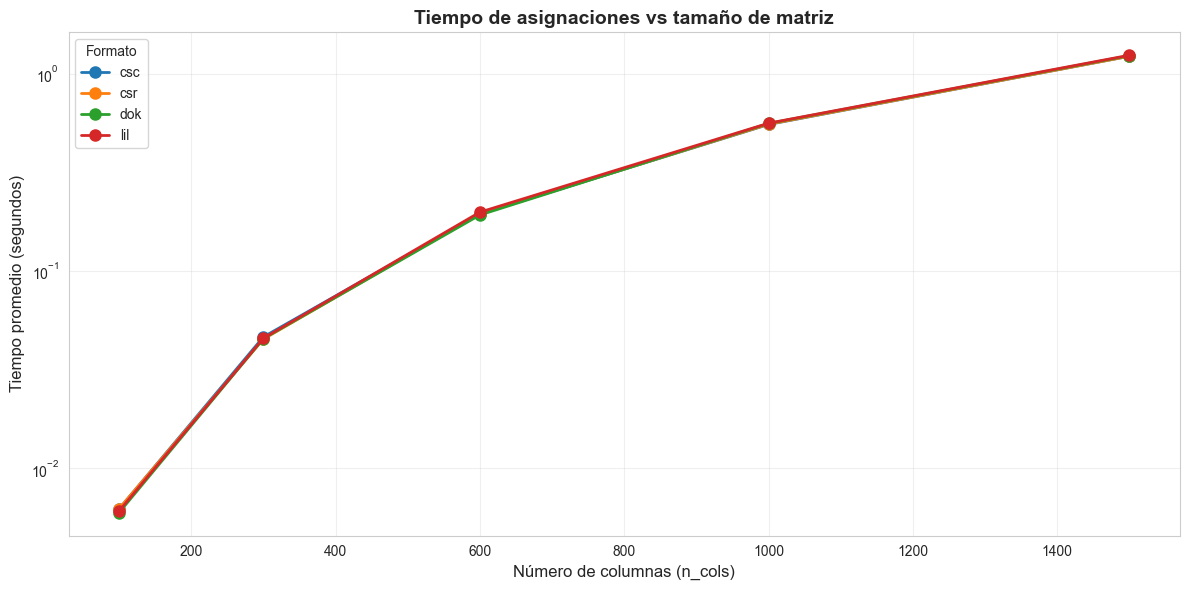

In [30]:
# GRÁFICO 2: Tiempo de asignaciones vs tamaño de matriz (n_cols)
fig, ax = plt.subplots(figsize=(12, 6))

group_size = df.groupby(['n_cols', 'fmt'])['tiempo_asignaciones_s'].mean().reset_index()

for fmt in sorted(df['fmt'].unique()):
    sub = group_size[group_size['fmt'] == fmt].sort_values('n_cols')
    ax.plot(sub['n_cols'], sub['tiempo_asignaciones_s'], marker='o', label=fmt, linewidth=2, markersize=8)

ax.set_title('Tiempo de asignaciones vs tamaño de matriz', fontsize=14, fontweight='bold')
ax.set_xlabel('Número de columnas (n_cols)', fontsize=12)
ax.set_ylabel('Tiempo promedio (segundos)', fontsize=12)
ax.set_yscale('log')
ax.legend(title='Formato', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


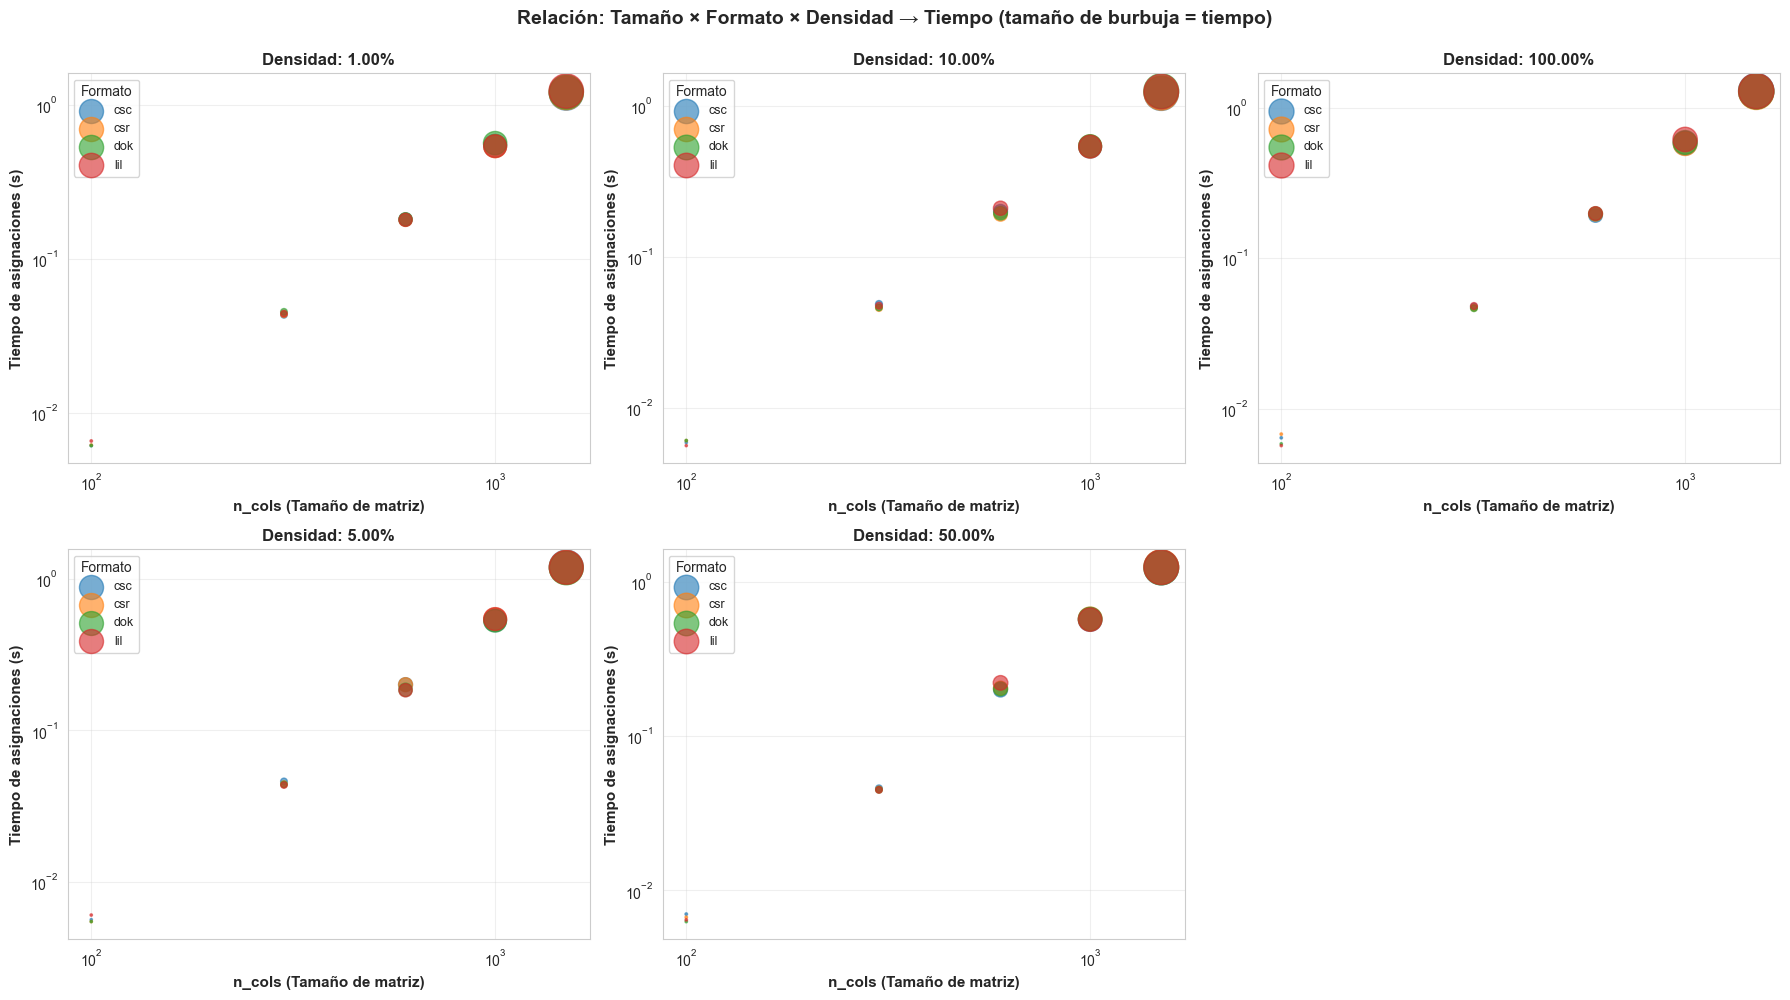

In [32]:
# GRÁFICO 1.5: Relación entre tamaño, formato, densidad y tiempo (bubble chart)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

densities = sorted(df['density_label'].unique())

for idx, density in enumerate(densities):
    sub = df[df['density_label'] == density]
    
    ax = axes[idx]
    
    for fmt in sorted(df['fmt'].unique()):
        sub_fmt = sub[sub['fmt'] == fmt]
        
        # x: n_cols (tamaño)
        # y: tiempo
        # size: tiempo * 500 (para que sea visible)
        scatter = ax.scatter(
            sub_fmt['n_cols'],
            sub_fmt['tiempo_asignaciones_s'],
            s=sub_fmt['tiempo_asignaciones_s'] * 500,
            alpha=0.6,
            label=fmt
        )
    
    ax.set_xlabel('n_cols (Tamaño de matriz)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Tiempo de asignaciones (s)', fontsize=11, fontweight='bold')
    ax.set_title(f'Densidad: {density}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(title='Formato', fontsize=9)

# Ocultar el último subplot si no se usa
if len(densities) < 6:
    axes[-1].set_visible(False)

plt.suptitle('Relación: Tamaño × Formato × Densidad → Tiempo (tamaño de burbuja = tiempo)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


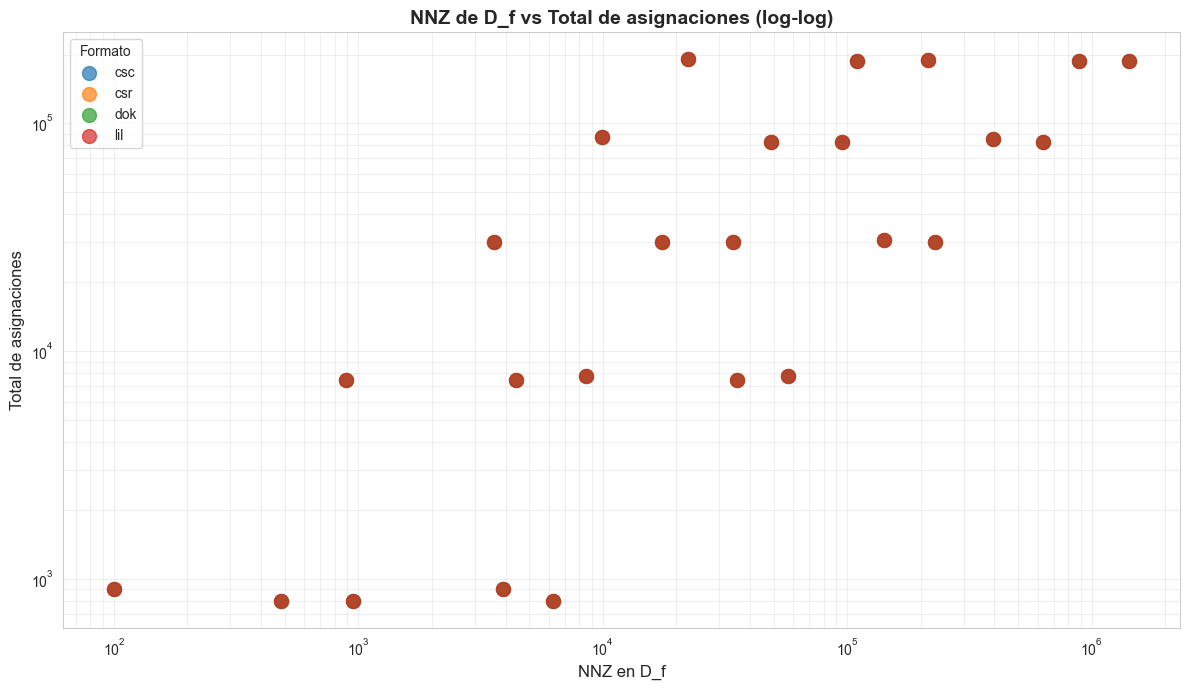

In [33]:
# GRÁFICO 5: NNZ vs Total de asignaciones (scatter log-log)
fig, ax = plt.subplots(figsize=(12, 7))

for fmt in sorted(df['fmt'].unique()):
    sub = df[df['fmt'] == fmt]
    ax.scatter(sub['nnz_D_f'], sub['total_asignaciones'], label=fmt, s=100, alpha=0.7)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('NNZ de D_f vs Total de asignaciones (log-log)', fontsize=14, fontweight='bold')
ax.set_xlabel('NNZ en D_f', fontsize=12)
ax.set_ylabel('Total de asignaciones', fontsize=12)
ax.legend(title='Formato', fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


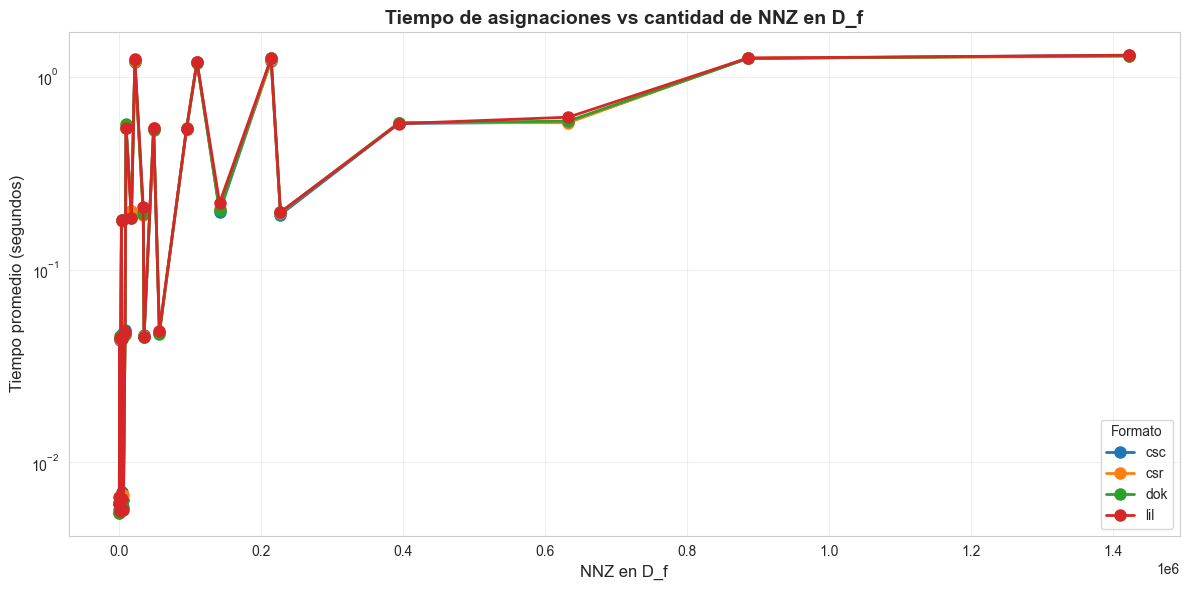

In [36]:
# GRÁFICO 6: Impacto del NNZ en el tiempo de asignaciones
fig, ax = plt.subplots(figsize=(12, 6))

group_nnz = df.groupby(['nnz_D_f', 'fmt'])['tiempo_asignaciones_s'].mean().reset_index()

for fmt in sorted(df['fmt'].unique()):
    sub = group_nnz[group_nnz['fmt'] == fmt].sort_values('nnz_D_f')
    ax.plot(sub['nnz_D_f'], sub['tiempo_asignaciones_s'], marker='o', label=fmt, linewidth=2, markersize=8)

ax.set_title('Tiempo de asignaciones vs cantidad de NNZ en D_f', fontsize=14, fontweight='bold')
ax.set_xlabel('NNZ en D_f', fontsize=12)
ax.set_ylabel('Tiempo promedio (segundos)', fontsize=12)
ax.set_yscale('log')
ax.legend(title='Formato', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


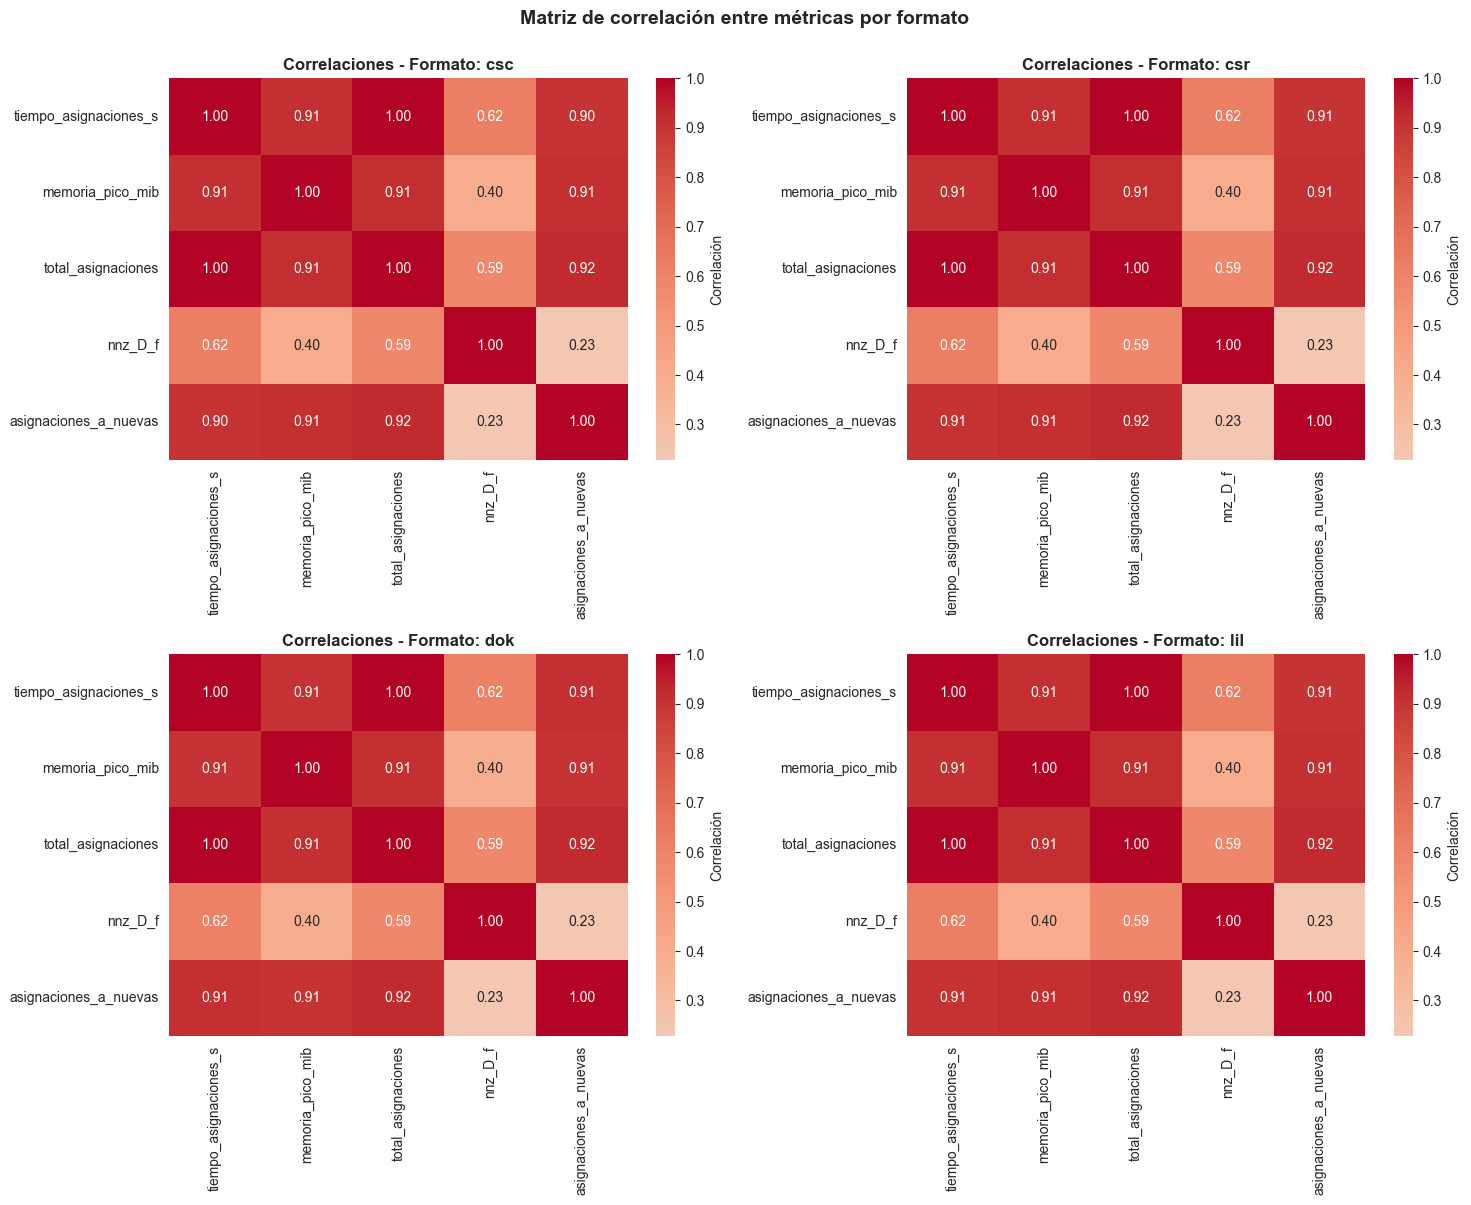

In [38]:
# GRÁFICO 8: Matriz de correlación entre métricas por formato
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

formats = sorted(df['fmt'].unique())
metrics = ['tiempo_asignaciones_s', 'memoria_pico_mib', 'total_asignaciones', 
           'nnz_D_f', 'asignaciones_a_nuevas']

for idx, fmt in enumerate(formats):
    sub = df[df['fmt'] == fmt][metrics]
    corr = sub.corr()
    
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[idx],
                cbar_kws={'label': 'Correlación'})
    axes[idx].set_title(f'Correlaciones - Formato: {fmt}', fontsize=12, fontweight='bold')

plt.suptitle('Matriz de correlación entre métricas por formato', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


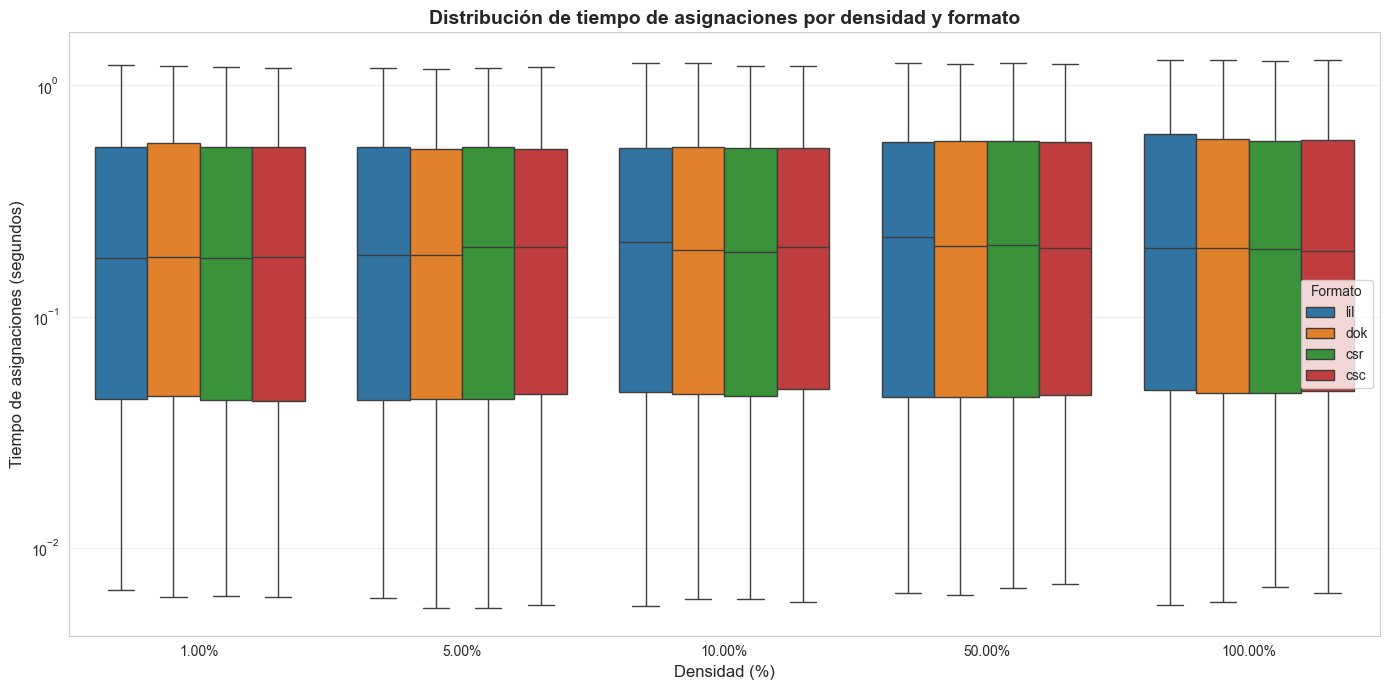

In [41]:
# GRÁFICO 9: Box plot de tiempo por formato y densidad
fig, ax = plt.subplots(figsize=(14, 7))

# Crear una columna auxiliar para mejor visualización
df['fmt_density'] = df['fmt'] + '\n' + df['density_label']

sns.boxplot(data=df, x='density_label', y='tiempo_asignaciones_s', hue='fmt', ax=ax)

ax.set_title('Distribución de tiempo de asignaciones por densidad y formato', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Densidad (%)', fontsize=12)
ax.set_ylabel('Tiempo de asignaciones (segundos)', fontsize=12)
ax.set_yscale('log')
ax.legend(title='Formato', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


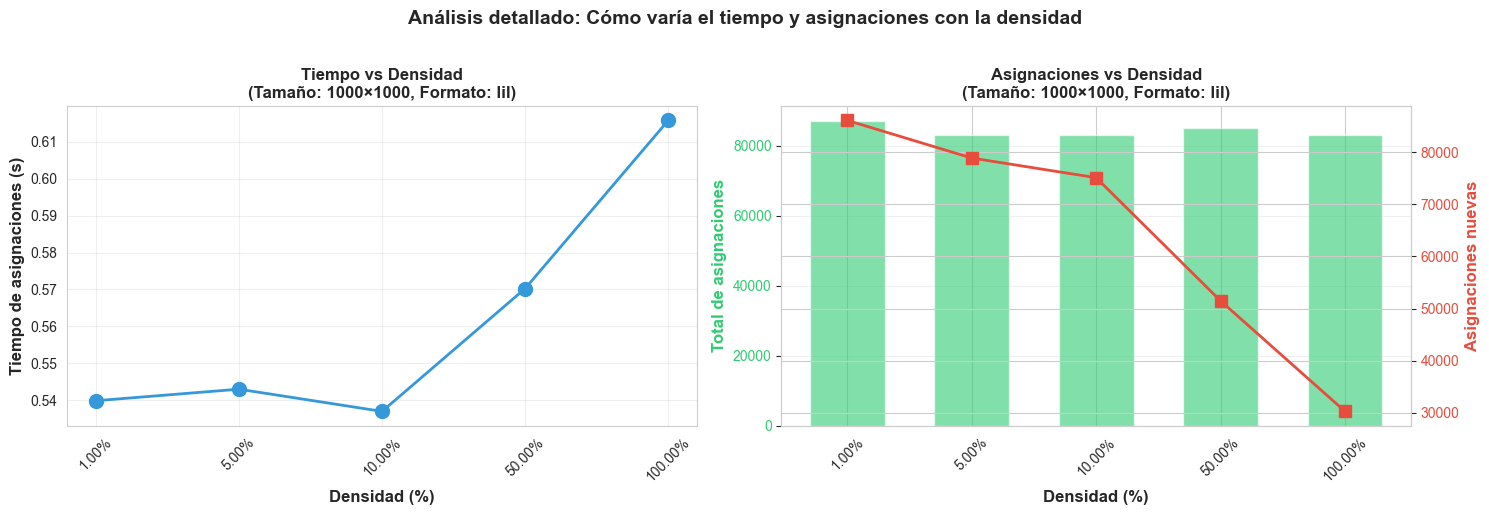


Datos mostrados para tamaño=1000, formato=lil:
density_label  tiempo_asignaciones_s  total_asignaciones  asignaciones_a_nuevas
        1.00%               0.539855               87000                  86111
        5.00%               0.542977               83000                  78890
       10.00%               0.536964               83000                  75118
       50.00%               0.570261               85000                  51476
      100.00%               0.615811               83000                  30275


In [42]:
# GRÁFICO INTERACTIVO: Variación por densidad y asignaciones (seleccionable)
# Seleccionar tamaño y formato
selected_size = 1000  # n_cols
selected_format = 'lil'

# Filtrar datos
filtered = df[(df['n_cols'] == selected_size) & (df['fmt'] == selected_format)].sort_values('density_ratio')

if len(filtered) == 0:
    print(f"No hay datos para tamaño={selected_size} y formato={selected_format}")
else:
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Gráfico 1: Tiempo vs Densidad
    ax1 = axes[0]
    ax1.plot(filtered['density_label'], filtered['tiempo_asignaciones_s'], 
             marker='o', linewidth=2, markersize=10, color='#3498db', label='Tiempo')
    ax1.set_xlabel('Densidad (%)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Tiempo de asignaciones (s)', fontsize=12, fontweight='bold')
    ax1.set_title(f'Tiempo vs Densidad\n(Tamaño: {selected_size}×{selected_size}, Formato: {selected_format})', 
                  fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Gráfico 2: Asignaciones vs Densidad
    ax2 = axes[1]
    ax2_twin = ax2.twinx()
    
    # Barras: Total asignaciones
    bars = ax2.bar(filtered['density_label'], filtered['total_asignaciones'], 
                    alpha=0.6, color='#2ecc71', label='Total asignaciones', width=0.6)
    
    # Línea: Asignaciones nuevas
    ax2_twin.plot(filtered['density_label'], filtered['asignaciones_a_nuevas'], 
                  marker='s', linewidth=2, markersize=8, color='#e74c3c', label='Asignaciones nuevas')
    
    ax2.set_xlabel('Densidad (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Total de asignaciones', fontsize=12, fontweight='bold', color='#2ecc71')
    ax2_twin.set_ylabel('Asignaciones nuevas', fontsize=12, fontweight='bold', color='#e74c3c')
    ax2.set_title(f'Asignaciones vs Densidad\n(Tamaño: {selected_size}×{selected_size}, Formato: {selected_format})', 
                  fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Leyendas
    ax2.tick_params(axis='y', labelcolor='#2ecc71')
    ax2_twin.tick_params(axis='y', labelcolor='#e74c3c')
    
    plt.suptitle(f'Análisis detallado: Cómo varía el tiempo y asignaciones con la densidad', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\nDatos mostrados para tamaño={selected_size}, formato={selected_format}:")
    print(filtered[['density_label', 'tiempo_asignaciones_s', 'total_asignaciones', 'asignaciones_a_nuevas']].to_string(index=False))


In [43]:
# GRÁFICO 10: Resumen de estadísticas por formato
print("\n" + "="*80)
print("RESUMEN DE ESTADÍSTICAS POR FORMATO")
print("="*80 + "\n")

for fmt in sorted(df['fmt'].unique()):
    sub = df[df['fmt'] == fmt]
    print(f"\n{'─'*40}")
    print(f"Formato: {fmt.upper()}")
    print(f"{'─'*40}")
    print(f"  Tiempo promedio:        {sub['tiempo_asignaciones_s'].mean():.6f} ± {sub['tiempo_asignaciones_s'].std():.6f} s")
    print(f"  Memoria pico promedio:  {sub['memoria_pico_mib'].mean():.3f} ± {sub['memoria_pico_mib'].std():.3f} MiB")
    print(f"  Asignaciones promedio:  {sub['total_asignaciones'].mean():.0f} ± {sub['total_asignaciones'].std():.0f}")
    print(f"  Asignaciones existentes (% del total): {(sub['asignaciones_a_existentes'].sum() / sub['total_asignaciones'].sum() * 100):.1f}%")
    print(f"  Asignaciones nuevas (% del total):     {(sub['asignaciones_a_nuevas'].sum() / sub['total_asignaciones'].sum() * 100):.1f}%")
    print(f"  Asignaciones por cero (% del total):   {(sub['asignaciones_por_cero'].sum() / sub['total_asignaciones'].sum() * 100):.1f}%")
    print(f"  NNZ en D_f promedio:    {sub['nnz_D_f'].mean():.0f}")
    print(f"  Densidad ratio promedio: {sub['density_ratio'].mean():.4f}")

print("\n" + "="*80)



RESUMEN DE ESTADÍSTICAS POR FORMATO


────────────────────────────────────────
Formato: CSC
────────────────────────────────────────
  Tiempo promedio:        0.405190 ± 0.463196 s
  Memoria pico promedio:  0.357 ± 0.324 MiB
  Asignaciones promedio:  62236 ± 70987
  Asignaciones existentes (% del total): 23.5%
  Asignaciones nuevas (% del total):     76.5%
  Asignaciones por cero (% del total):   96.9%
  NNZ en D_f promedio:    175082
  Densidad ratio promedio: 0.3320

────────────────────────────────────────
Formato: CSR
────────────────────────────────────────
  Tiempo promedio:        0.405196 ± 0.463215 s
  Memoria pico promedio:  0.357 ± 0.324 MiB
  Asignaciones promedio:  62236 ± 70987
  Asignaciones existentes (% del total): 23.5%
  Asignaciones nuevas (% del total):     76.5%
  Asignaciones por cero (% del total):   96.9%
  NNZ en D_f promedio:    175082
  Densidad ratio promedio: 0.3320

────────────────────────────────────────
Formato: DOK
───────────────────────────────────